# Gerardo de Miguel González

# Feature Selection Proof of Concept

## References

**::GMG::** I've used the following *introductory* references:

  - [DataCamp](https://www.datacamp.com/community/tutorials/feature-selection-python) Beginner's Guide to Feature Selection in Python. *Learn about the basics of feature selection and how to implement and investigate various feature selection techniques in Python*. Sayak Paul. September 25th, 2018.
  - [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/) Introduction to Feature Selection methods with an example (or how to select the right variables?). Saurav Kaushik, december 1, 2016.  
  
**::GMG::** There is also a more *in-deep* reference, a two part article by [Lahiru Liyanapathirana](https://towardsdatascience.com/@lahiru.tjay):

  - Machine Learning Workflow on Diabetes Data : [Part 01](https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8)
  - Machine Learning Workflow on Diabetes Data : [Part 02](https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-02-11262b7f7a5c)
  
where *cross-validation* techniques are used for _model selection_ and _feature selection_ within the workflow. I appreciate the fact that [the code from the article](https://github.com/LahiruTjay/Machine-Learning-With-Python/blob/master/Machine%20Learning%20Workflow%20on%20Diabetes%20Data.ipynb) is *available* in Github and I can copycat the workflow to learn it by heart and apply it to my projects.

**::GMG::** Scikit-learn has also a wealth of material to read and learn:

  - [Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)

## Libraries

In [1]:
#::GMG::General
import pandas as pd
import numpy as np

In [2]:
#::GMG::Visualization
import matplotlib.pyplot as plt

In [3]:
#::GMG::Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [4]:
#::GMG::Train/Test and (Stratified) K-fold Split
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [5]:
#::GMG::wrapper feature selection standard and with cross vañidation
from sklearn.feature_selection import RFE 
from sklearn.feature_selection import RFECV

In [35]:
#::GMG::evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [45]:
#::GMG::Helper for precision-recall curve
from inspect import signature

## Dataset

### load

**::GMG::** You may [download the data from kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database/downloads/pima-indians-diabetes-database.zip/1) in zipped csv format (which *includes a header* with the column names by the way) using [the reference provided](https://www.kaggle.com/uciml/pima-indians-diabetes-database) in the Datacamp article *if you have an account in kaggle*. I haven't checked it but you should be able [to use the kaggle API](https://medium.com/@yvettewu.dw/tutorial-kaggle-api-google-colaboratory-1a054a382de0) too to automate the download from code *with an API key* created with your account. 

**::GMG::** I've already downloaded *manually from kaggle* (with my account) the csv dataset and placed it in a data folder.

In [6]:
#::GMG::Location of the downloaded dataset csv file
!ls data

pima-indians-diabetes.csv


In [7]:
#::GMG::Dataframe
data = pd.read_csv("data/pima-indians-diabetes.csv")

In [8]:
#::GMG::Show some samples
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
#::GMG::Show some samples
data.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [10]:
#::GMG::Get some statistics of the features and classification variable
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### preprocessing

**::GMG::** To let the dataset ready to work on, I must do some preparatory tasks first. These tasks are related to the fact that there are some *dirty* features, i.e `Glucose`, `Insulin`, `BloodPressure`, `SkinThickness`, and `BMI` which have *zeros* and those are not valid values (*outliers*).

In [11]:
print("Zero Plasma Glucose  Total : ", data[data.Glucose == 0].shape[0])
print("Zero Insulin level   Total : ", data[data.Insulin == 0].shape[0])
print("Zero Blood Pressure  Total : ", data[data.BloodPressure == 0].shape[0])
print("Zero Skin Thickness  Total : ", data[data.SkinThickness == 0].shape[0])
print("Zero Body Mass Index Total : ", data[data.BMI == 0].shape[0])

Zero Plasma Glucose  Total :  5
Zero Insulin level   Total :  374
Zero Blood Pressure  Total :  35
Zero Skin Thickness  Total :  227
Zero Body Mass Index Total :  11


**::GMG::** Some of the outliers may somehow safely *removed*.

In [12]:
#::GMG::Hard choice to make ... remove the rows where the “BloodPressure”, 
#       “BMI” and “Glucose” are zero (small number of rows, low impact)
data_mod = data[(data.BloodPressure != 0) & 
                (data.BMI != 0) & 
                (data.Glucose != 0)
               ]
print('Data shape after removing outliers: {}'.format(data_mod.shape))

Data shape after removing outliers: (724, 9)


**::GMG::** The problem with `Insulin` and `Skin Thickness` is that they are a *significant part* of the dataset. They cannot be removed. I may use an *imputation method* to fill in the zeros, i.e. put *average/mean* values, but in this case putting a mean value to the blood pressure column would send a *wrong signal* to the model. I may also avoid using the features involved if they are not *relevant* or are *redundant*. Feature selection by filtering might come in handy and help with that. But the filter is going to use the outliered feature ... so I'm in doubt here!

In [13]:
#::GMG::Some basic (Pearson) correlations with Outcome
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
correlation = data_mod.corr()
correlation['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.488384
BMI                         0.299375
Age                         0.245741
Pregnancies                 0.224417
DiabetesPedigreeFunction    0.184947
BloodPressure               0.166703
Insulin                     0.145488
SkinThickness               0.092030
Name: Outcome, dtype: float64

**::GMG::** Based on this basic analysis I might avoid using `Skin Thickness` but not `Insulin`. But I'm going to *keep the features as they are* at the moment and let the wrapper decide.

In [15]:
#::GMG::Beware of the imbalance dataset ...
#       https://www.quora.com/What-is-an-imbalanced-dataset
#       https://www.datacamp.com/community/tutorials/diving-deep-imbalanced-data
#       https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
#       How do I check?
# https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8
data_mod.groupby('Outcome').size()

Outcome
0    475
1    249
dtype: int64

Text(0, 0.5, 'Frequency %')

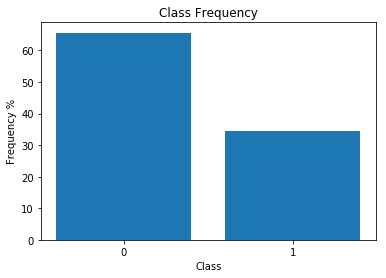

In [16]:
#::GMG::Say, 0 healthy, 1 diabetes
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.chararray.astype.html
# https://matplotlib.org/gallery/lines_bars_and_markers/categorical_variables.html
classes = data_mod.Outcome.values
unique, counts = np.unique(classes, return_counts=True)
plt.bar(unique.astype(np.character),100*counts/classes.size)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency %')

## Wrapper: Recursive Feature Elimination (RFE)

**::GMG::** The Recursive Feature Elimination (or RFE) works by *recursively removing attributes* and *building a model* on those attributes that remain. It uses the *model accuracy* to identify which attributes (and combination of attributes) *contribute the most* to predicting the target attribute. See [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html). There's also a [user guide](https://scikit-learn.org/stable/modules/feature_selection.html#rfe) and two examples:

 - [RFE on pixels](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html)
 - [Recursive feature elimination with cross-validation](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html)

### feature selection

In [23]:
#::GMG::Feature extraction wrapper method from Datacamp reference
#       Logistic Regression classifier as accuracy estimator to select the top 3 features
#       The “balanced” mode uses the values of y to automatically adjust weights inversely 
#       proportional to class frequencies in the input data as 
#       n_samples / (n_classes * np.bincount(y))
#
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#::NOTE::Why three?
model = LogisticRegression(solver = 'liblinear', 
                           class_weight = 'balanced', 
                           random_state = 1)
rfe = RFE(estimator = model, n_features_to_select = 3)

In [24]:
#::GMG::70/30 split, this is not done in the datacamp tutorial
#::NOTE::I know the dataset is imbalanced so I use stratify
train, test = train_test_split(data_mod, 
                               test_size = 0.3,
                               stratify = data_mod.Outcome,
                               random_state = 27)

In [25]:
#::GMG::Split features/target in train and test
train_features = train.iloc[:,:train.shape[1] - 1]
train_target = train['Outcome']
test_features = test.iloc[:,:test.shape[1] - 1]
test_target = test['Outcome']

In [26]:
train_features.shape

(506, 8)

In [27]:
test_features.shape

(218, 8)

In [28]:
#::GMG::Fit the RFE model and then the underlying estimator on the selectedvfeatures
rfe.fit(X = train_features, y = train_target)

RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=3, step=1, verbose=0)

In [29]:
#::GMG::no suprise in the number of selected features :)
print("Num Features: %s" % (rfe.n_features_))

Num Features: 3


In [30]:
#::GMG::Getting to kow the ropes ...
rfe.get_support()

array([ True, False, False, False, False,  True,  True, False])

In [31]:
#::GMG::Understanding how selection is made using support and ranking
print("Features: \n%s \n" % 
      [values for values in zip(data.columns, 
                                rfe.support_, 
                                rfe.ranking_)
      ]
     )

Features: 
[('Pregnancies', True, 1), ('Glucose', False, 2), ('BloodPressure', False, 3), ('SkinThickness', False, 5), ('Insulin', False, 6), ('BMI', True, 1), ('DiabetesPedigreeFunction', True, 1), ('Age', False, 4)] 



In [32]:
#::GMG::How to get the selected features in a pythonic way ...
print("Selected Features: %s" % 
      [value for value, supported in zip(data.columns, rfe.support_) if supported]
     )

Selected Features: ['Pregnancies', 'BMI', 'DiabetesPedigreeFunction']


**::GMG::** RFE chose the top 3 features as `Pregnancies`, `BMI`, and `DiabetesPedigreeFunction`. These are *marked True* in the support array and *marked with a choice “1”* in the ranking array. This, in turn, indicates *the strength* of these features.

In [33]:
#::GMG::This is the estimator/model trained (fit) with selected features
# ::NOTE::Should I optimize its hyperparameters like C, penalty, ... over CV k-folds?
rfe.estimator_

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [34]:
#::GMG::All the parameters used
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE.get_params
rfe.get_params()

{'estimator__C': 1.0,
 'estimator__class_weight': 'balanced',
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'warn',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': 1,
 'estimator__solver': 'liblinear',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'n_features_to_select': 3,
 'step': 1,
 'verbose': 0}

### prediction and metrics

In [36]:
#::GMG::Reduce X to the selected features and then predict using the underlying estimator
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE.predict
pred = rfe.predict(X = test_features)

In [37]:
#::GMG::Basic Scores
print('Score Train: {:4.3f} \nScore Test: {:4.3f}'.format(
    rfe.score(X = train_features, y = train_target),
    rfe.score(X = test_features, y = test_target)
    )
)

Score Train: 0.658 
Score Test: 0.706


In [38]:
#::GMG::Get the confusion matrix
# https://en.wikipedia.org/wiki/Confusion_matrix
# # https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
cm_rfe = confusion_matrix(y_true = test_target, y_pred = pred)
print(cm_rfe)

[[107  36]
 [ 28  47]]


In [39]:
#::GMG::Flatten the confusion matrix and get its parts
# https://www.w3resource.com/numpy/manipulation/ravel.php
tn, fp, fn, tp = cm_rfe.ravel()
tn, fp, fn, tp

(107, 36, 28, 47)

**::GMG::** *Sensitivity* and *specificity* are statistical measures of the performance of a binary classification test, also known in statistics as a classification function, that are widely used in medicin. ([wikipedia](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)). I can compute them from values in the confusion matrix!

In [40]:
#::GMG::specificity, selectivity or true negative rate (TNR)
# https://en.wikipedia.org/wiki/Sensitivity_and_specificity
specificity = tn / (tn + fp)
print('{:4.3f}'.format(specificity))

0.748


In [41]:
#::GMG::sensitivity, recall, hit rate, or true positive rate (TPR)
# https://en.wikipedia.org/wiki/Sensitivity_and_specificity
sensitivity = tp / (tp + fn)
print('{:4.3f}'.format(sensitivity))

0.627


In [42]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html
print('{:4.3f}'.format(
    balanced_accuracy_score(y_true = test_target.values, y_pred = pred)))

0.687


In [43]:
#::GMG::The classification report shows all the metrics ...
target_names = ['healthy', 'diabetes']
print(classification_report(y_true = test_target.values, y_pred = pred, 
                            target_names=target_names, digits = 3))

              precision    recall  f1-score   support

     healthy      0.793     0.748     0.770       143
    diabetes      0.566     0.627     0.595        75

   micro avg      0.706     0.706     0.706       218
   macro avg      0.679     0.687     0.682       218
weighted avg      0.715     0.706     0.710       218



In [44]:
#::GMG::I use prediction as porbabilities for AUC and precision-recall curve
prob = rfe.predict_proba(X = test_features)[:, 1]

In [46]:
#::GMG::Precision-Recall Curve
precision, recall, _ = precision_recall_curve(
    y_true = test_target, 
    probas_pred = prob, 
    pos_label = 1
)

In [48]:
#::GMG::AUC (precision, recall)
auc_pr = auc(x = recall, y = precision)
print('AUC Precision/Recall: {:4.3f}'.format(auc_pr))

AUC Precision/Recall: 0.640


In [50]:
#::GMG::average precision 
apc = average_precision_score(y_true = test_target, 
                              y_score = prob, 
                              pos_label = 1, 
                              average = 'weighted')
print('Average Precision (Weighted): {:4.3f}'.format(apc))

Average Precision (Weighted): 0.643


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.64')

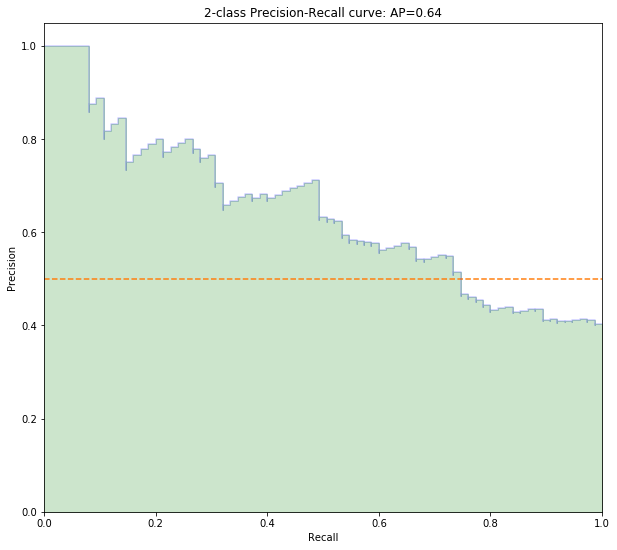

In [51]:
#::GMG::Plot Recall-Precision Curve
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.figure(figsize = (10,9))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--', color = 'C1')
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='g', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(apc))

**::GMG::** where should I integrate feature selection in my machine learning pipeline? *Datacamp* reference author states:

> you should include the feature selection step before feeding the data to the model for training especially when you are using accuracy estimation methods such as cross-validation. This ensures that feature selection is performed on the data fold right before the model is trained. But if you perform feature selection first to prepare your data, then perform model selection and training on the selected features then it would be a blunder. If you perform feature selection on all of the data and then cross-validate, then the test data in each fold of the cross-validation procedure was also used to choose the features, and this tends to bias the performance of your machine learning model.

## Recursive Feature Elimination with Cross-Validation (RFECV)

**::GMG::** there's a way of estimating the number of features using cross-validation, see the [example](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html) and [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html). 


In [91]:
#::GMG::Split features/target in train and test is already done
train_features.shape 

(614, 8)

In [92]:
train_target.shape

(614,)

In [93]:
test_features.shape 

(154, 8)

In [94]:
test_target.shape

(154,)

In [95]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")

In [96]:
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')

In [97]:
rfecv.fit(train_features, train_target)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
   estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

In [98]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 6


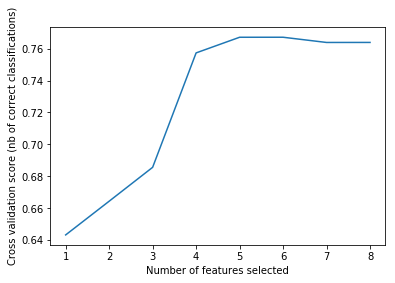

In [99]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [100]:
rfecv.n_features_

6

In [101]:
rfecv.support_

array([ True,  True,  True,  True, False,  True,  True, False])

In [102]:
rfecv.ranking_

array([1, 1, 1, 1, 3, 1, 1, 2])

In [103]:
#::GMG::Understanding how selection is made using support and ranking
print("Features: %s" % 
      [values for values in zip(data.columns, 
                                rfecv.support_, 
                                rfecv.ranking_)
      ]
     )

Features: [('Pregnancies', True, 1), ('Glucose', True, 1), ('BloodPressure', True, 1), ('SkinThickness', True, 1), ('Insulin', False, 3), ('BMI', True, 1), ('DiabetesPedigreeFunction', True, 1), ('Age', False, 2)]


In [104]:
#::GMG::How to get the selected features in a pythonic way ...
print("Selected Features: %s" % 
      [value for value, supported in zip(data.columns, rfecv.support_) if supported]
     )

Selected Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction']


### Prediction and metrics

In [106]:
#::GMG::Reduce X to the selected features and then predict using the underlying estimator
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV.predict
pred_cv = rfecv.predict(X = test_features)

In [112]:
#::GMG::Confusion matrix (baseline performance analysis)
cm_rfe_cv = confusion_matrix(y_true = test_target.values, y_pred = pred_cv)
tn, fp, fn, tp = cm_rfe_cv.ravel()
print(cm_rfe_cv)

[[92 13]
 [24 25]]


In [127]:
#::GMG::specificity, selectivity or true negative rate (TNR)
# https://en.wikipedia.org/wiki/Sensitivity_and_specificity
specificity = tn / (tn + fp)
#::GMG::sensitivity, recall, hit rate, or true positive rate (TPR)
# https://en.wikipedia.org/wiki/Sensitivity_and_specificity
sensitivity = tp / (tp + fn)
print('Specificity: {:4.3f} \nSensitivity: {:4.3f}'.format(specificity, sensitivity))

Specificity: 0.876 
Sensitivity: 0.510


In [124]:
#::GMG::The balanced accuracy in binary and multiclass classification problems to deal 
#       with imbalanced datasets. It is defined as the average of recall obtained on each class
print('Balanced Accuracy Score: {:4.3f}'.format(
    balanced_accuracy_score(y_true = test_target.values, y_pred = pred_cv)))

Balanced Accuracy Score: 0.693


In [129]:
target_names = ['healthy', 'diabetes']
print('Classification Report:\n')
print(classification_report(y_true = test_target.values, 
                            y_pred = pred_cv, 
                            target_names = target_names, 
                            digits = 3)
     )

Classification Report:

              precision    recall  f1-score   support

     healthy      0.793     0.876     0.833       105
    diabetes      0.658     0.510     0.575        49

   micro avg      0.760     0.760     0.760       154
   macro avg      0.725     0.693     0.704       154
weighted avg      0.750     0.760     0.751       154



### Notes

In [52]:
#::GMG::Score of trained estimator over training set(?)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE.score
print('Score (train): {:4.3f}'.format(rfe.score(train_features, train_target)))

Score (train): 0.687


In [54]:
#::GMG::Score of trained estimator over test set(?)
print('Score (test): {:4.3f}'.format(rfe.score(test_features, test_target)))

Score (test): 0.727


**::GMG::** If I want to use the (split) dataset with the selected features with other classification algorithms I can get them from `rfe` object

In [32]:
#::GMG::Perform the transformation of dataset with the selected features
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE.transform
train_features_fs = rfe.transform(X = train_features)
test_features_fs = rfe.transform(X = test_features)

In [33]:
train_features_fs.shape

(614, 3)

In [34]:
test_features_fs.shape

(154, 3)

In [83]:
#::GMG::Get the 'new' dataset pandas dataframe with the selected features
#       I'm not sure if this is necessary at all ... maybe if you're going to use it
#       further for ML task ...
train_fs = pd.DataFrame(
    data = train_features_fs, 
    columns = [value for value, supported in zip(data.columns, rfe.support_) if supported]
)

In [84]:
#::GMG::Adding new column to existing DataFrame in Python pandas
# https://stackoverflow.com/questions/12555323/adding-new-column-to-existing-dataframe-in-python-pandas
train_fs = train_fs.assign(Outcome = train_target.values)

In [86]:
train_fs.head()

,Pregnancies,BMI,DiabetesPedigreeFunction,Outcome
0,10.0,27.7,0.182,0
1,2.0,21.1,0.647,0
2,8.0,28.4,0.259,1
3,0.0,59.4,2.420,1
4,0.0,20.0,0.236,0


In [87]:
train_fs.shape

(614, 4)

In [65]:
test_fs = pd.DataFrame(
    data = test_features_fs, 
    columns = [value for value, supported in zip(data.columns, rfe.support_) if supported]
)

In [70]:
test_fs = test_fs.assign(Outcome = test_target.values)

In [71]:
#::GMG::Outcome yields NaN and I don't know why!!!
test_fs.head()

,Pregnancies,BMI,DiabetesPedigreeFunction,Outcome
0,7.0,28.8,0.687,0
1,1.0,21.8,0.416,0
2,8.0,32.7,0.719,1
3,5.0,28.8,0.153,0
4,5.0,41.0,0.346,1


In [72]:
test_fs.shape

(154, 4)